# DogFaceNet version 3

### Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

### Data pre-processing

In [2]:
PATH = '../data/dogfacenet/'
PATH_IMAGES = PATH + 'images/'
PATH_RESIZED = PATH + 'resized/'

# Size of the input image into the network
SIZE = (100,100,3)
TEST_SPLIT = 0.05
VALID_SPLIT = 0.1

In [3]:
filenames = os.listdir(PATH_RESIZED)

i = 0

# Remove unique examples
while i<len(filenames):
    files = os.listdir(PATH_RESIZED + filenames[i])
    if len(files)<=1:
        filenames = filenames[:i] + filenames[i+1:]
    else:
        i += 1

# Compute the number of images
nbof_images = 0
for i in range(0,len(filenames)):
    files = os.listdir(PATH_RESIZED + filenames[i])
    nbof_images += len(files)

print("Number of images: " + str(nbof_images))
    
w, h, c = SIZE

images = np.empty((nbof_images,w,h,c))
labels = np.empty(nbof_images, dtype=int)

label = 0

index = 0

# Load images into numpy arrays
for i in tqdm_notebook(range(len(filenames))):
    files = os.listdir(PATH_RESIZED + filenames[i])
    for file in files:
        labels[index] = label
        # Read image
        image = sk.io.imread(PATH_RESIZED + filenames[i] + '/' + file)

        # Add the image to the table
        images[index] = image
        
        index += 1
    label += 1

# Normalize images:
images /= 255.
assert len(labels)==len(images)

Number of images: 5503


HBox(children=(IntProgress(value=0, max=1476), HTML(value='')))

In [4]:
w, h, c = SIZE

nbof_test = int(len(images)*TEST_SPLIT)

images_test = images[-nbof_test:]
labels_test = labels[-nbof_test:]

nbof_valid = int(len(images)*VALID_SPLIT)

images_valid = images[-nbof_test-nbof_valid:-nbof_test]
labels_valid = labels[-nbof_test-nbof_valid:-nbof_test]

images_train = images[:-nbof_test-nbof_valid]
labels_train = labels[:-nbof_test-nbof_valid]

print("Total number of images: " + str(len(labels)))
print("Number of test images: " + str(len(labels_test)))
print("Number of validation images: " + str(len(labels_valid)))
print("Number of training images: " + str(len(labels_train)))
print("Number of classes in the training set: " + str(labels_train[-1] - labels_train[0]))


# Creates the pairs

nbof_pairs = (len(images_valid)//2)*2 # it has to be multiple of 2

print("Number of pairs: " + str(nbof_pairs))

pairs = np.empty((nbof_pairs,w,h,c))
issame = np.empty(nbof_pairs, dtype=int)
y_pairs = np.empty(nbof_pairs)

nbof_same = 0

for i in tqdm_notebook(range(0,nbof_pairs,2)):
    ## alea_issame will decide if the new pair will be a pair of same dog images or a pair of different
    alea_issame = np.random.rand()

    if alea_issame < 0.5: # Then it will be a pair of same dogs
        # we randomly choose a dog
        choice = np.random.randint(len(labels_valid))
        
        # we extract the images of this class
        chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice])])
        chosen_labels = list(labels_valid[np.equal(labels_valid,labels_valid[choice])])
        
        while len(labels_valid[np.equal(labels_valid,labels_valid[choice])]) < 2:
            choice = np.random.randint(len(labels_valid))
            chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice])])
            chosen_labels = list(labels_valid[np.equal(labels_valid,labels_valid[choice])])
            
        # we then randomly choose two pictures of this class
        choice1 = np.random.randint(len(chosen_images))
        pairs[i] = chosen_images[choice1]
        y_pairs[i] = chosen_labels[choice1]
        
        save = np.copy(chosen_images)
        chosen_images = chosen_images[:choice1] + chosen_images[choice1+1:]
        if len(chosen_images) == 0:
            print("Bug!")
            print(save)
        choice2 = np.random.randint(len(chosen_images))
        pairs[i+1] = chosen_images[choice2]
        y_pairs[i+1] = chosen_labels[choice2]
        
        issame[i] = issame[i+1] = 1
        
        nbof_same += 1
        
    else: # Then it will be a pair of different dogs
        # we randomly choose two dogs
        choice1 = np.random.randint(len(labels_valid))
        
        # we extract the images of the class
        chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice1])])
        chosen_labels = list(labels_valid[np.equal(labels_valid,labels_valid[choice1])])
        
        # we choose an image of this class
        choice = np.random.randint(len(chosen_images))
        #print(choice)
        pairs[i] = chosen_images[choice]
        y_pairs[i] = chosen_labels[choice]
        
        choice2 = np.random.randint(len(labels_valid))
        
        # check if we have two different classes
        while labels_valid[choice2] == labels_valid[choice1]:
            choice2 = np.random.randint(len(labels_valid))
        
        chosen_images = list(images_valid[np.equal(labels_valid,labels_valid[choice2])])
        chosen_labels = list(labels_valid[np.equal(labels_valid,labels_valid[choice2])])
        
        # we choose an image of this class
        choice = np.random.randint(len(chosen_images))
        
        pairs[i+1] = chosen_images[choice]
        y_pairs[i+1] = chosen_labels[choice]
        
        issame[i] = issame[i+1] = 0

print("Number of same images: " + str(nbof_same))
print("Number of validation images: " + str(len(labels_valid)))

Total number of images: 5503
Number of test images: 275
Number of validation images: 550
Number of training images: 4678
Number of classes in the training set: 1282
Number of pairs: 550


HBox(children=(IntProgress(value=0, max=275), HTML(value='')))


Number of same images: 144
Number of validation images: 550


In [5]:
# check all the pairs
for i in range(0,len(y_pairs),2):
    if issame[i] == 0:
        if y_pairs[i]==y_pairs[i+1]:
            print(y_pairs[i],y_pairs[i+1],issame[i])
    if issame[i] == 1:
        if y_pairs[i]!=y_pairs[i+1]:
            print(y_pairs[i],y_pairs[i+1],issame[i])

[1 1 1 1 0 0 0 0 1 1]
[1356. 1356. 1314. 1314. 1330. 1430. 1406. 1332. 1392. 1392.]


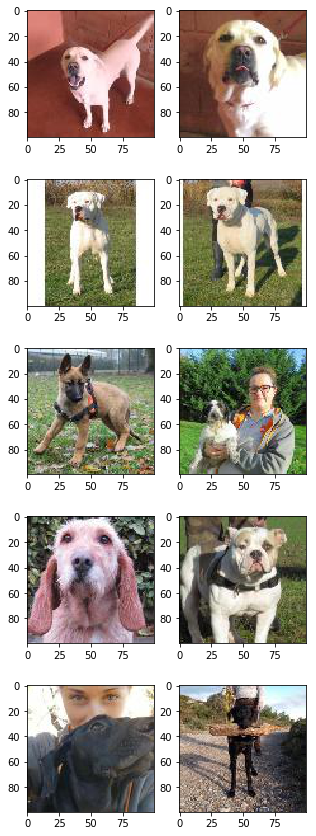

In [6]:
# check some pairs
s = 0
n = 5
print(issame[2*s:(n+s)*2])
print(y_pairs[2*s:(n+s)*2])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i])
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1])

In [7]:
labels_train = tf.keras.utils.to_categorical(labels_train)
labels_test = tf.keras.utils.to_categorical(labels_test)

y_pairs = tf.keras.utils.to_categorical(y_pairs)

print(labels_train)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


### Loss and model definition

In [8]:
from tensorflow.keras import backend as K

m = 0.5
s = 64.
out_num = len(labels_train[0])

def cosineLoss(y_true,y_pred):
    # Compute the softmax like 
    s_cos = tf.multiply(y_pred, s)
    s_cos_m = tf.add(s_cos, -m)
    exp_s_cos = K.exp(s_cos)
    exp_s_cos_m = K.exp(s_cos_m)
    
    mask = tf.cast(y_true, tf.float32)
    m_mask = tf.multiply(mask,m)
    s_cos_m_mask = tf.subtract(s_cos, m_mask)
    den = K.sum(s_cos_m_mask,1)
    den_stacked = K.stack([den]*out_num,axis=-1)
    
    out = tf.divide(exp_s_cos_m,den_stacked)
    # Compute the categorical crossentropy
    return K.categorical_crossentropy(y_true,out)

#### Model number 1

In [27]:
def net(input_shape, emb_size=4):
    input_image = tf.keras.Input(input_shape,name='image_input')
    
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(input_image)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    emb = tf.keras.layers.Dense(32, activity_regularizer='l2')(x)
    
    out = tf.keras.layers.Dense(out_num, kernel_regularizer='l2', use_bias=False, name='output')(emb)
    model = tf.keras.Model(inputs=[input_image], outputs=out)
    return model

w, h, c = SIZE
input_shape = (w, h, c,)
model = net(input_shape)
model.compile(tf.keras.optimizers.Adam(),loss={'output':cosineLoss},metrics=['accuracy'])

#### Model number 2

In [9]:
w, h, c = SIZE
input_shape = (w, h, c,)

base_model = tf.keras.applications.ResNet50(include_top=False,weights='imagenet', input_shape=input_shape)

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
emb = tf.keras.layers.Dense(32, activity_regularizer='l2')(x)

out = tf.keras.layers.Dense(out_num, kernel_regularizer='l2', use_bias=False, name='output')(emb)

model = tf.keras.Model(inputs=base_model.input, outputs=out)
model.compile(tf.keras.optimizers.Adam(),loss={'output':cosineLoss},metrics=['accuracy'])
model.summary()

c:\users\guillaume\anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

activation_9 (Activation)       (None, 25, 25, 256)  0           add_2[0][0]                      
__________________________________________________________________________________________________
res3a_branch2a (Conv2D)         (None, 13, 13, 128)  32896       activation_9[0][0]               
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 13, 13, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 13, 13, 128)  0           bn3a_branch2a[0][0]              
__________________________________________________________________________________________________
res3a_branch2b (Conv2D)         (None, 13, 13, 128)  147584      activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branc

__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 13, 13, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_6 (Add)                     (None, 13, 13, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_18[0][0]              
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 13, 13, 512)  0           add_6[0][0]                      
__________________________________________________________________________________________________
res4a_branch2a (Conv2D)         (None, 7, 7, 256)    131328      activation_21[0][0]              
__________________________________________________________________________________________________
bn4a_branc

__________________________________________________________________________________________________
bn4d_branch2b (BatchNormalizati (None, 7, 7, 256)    1024        res4d_branch2b[0][0]             
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 7, 7, 256)    0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 7, 7, 1024)   263168      activation_32[0][0]              
__________________________________________________________________________________________________
bn4d_branch2c (BatchNormalizati (None, 7, 7, 1024)   4096        res4d_branch2c[0][0]             
__________________________________________________________________________________________________
add_10 (Add)                    (None, 7, 7, 1024)   0           bn4d_branch2c[0][0]              
          

__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 4, 4, 512)    2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 4, 4, 512)    0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 4, 4, 512)    2359808     activation_43[0][0]              
__________________________________________________________________________________________________
bn5b_branch2b (BatchNormalizati (None, 4, 4, 512)    2048        res5b_branch2b[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 4, 4, 512)    0           bn5b_branch2b[0][0]              
__________

### Train the model

In [10]:
model.fit(
    [images_train],
    [labels_train],
    batch_size=128,
    epochs=1
    #validation_data=([labels_test],[y_test])
)

Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[128,64,25,25] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/zeros_278}} = Fill[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/res2b_branch2b/BiasAdd_grad/BiasAddGrad"], index_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/Shape_95, training/Adam/gradients/zeros_278/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss/add_1/_3289}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_23156_loss/add_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
